# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP that is wide and deep.  
Train on copious simulated data.  
Use uniform but realistic RNA lengths.  
74% accuracy.  

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-17 14:10:13 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1000  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-17 14:10:14.364767: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep        
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-17 14:10:14 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1000.0
Average ORF length: 674.5634727272727
NC seqs
Average RNA length: 1000.0
Average ORF length: 179.77161818181818
2021-08-17 14:10:36 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
pc_all=None
nc_all=None
dp=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
2021-08-17 14:10:36 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

2021-08-17 14:10:58 EDT


In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-17 14:10:58 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-17 14:10:58.523481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 14:10:58.593191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 14:10:58.595039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-17 14:10:58.595101: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 14:10:58.601433: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 14:10:58.601531: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-17 14:10:59 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-17 14:10:59.200819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 14:10:59.220772: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-17 14:11:05.631223: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 154/2084 [=>............................] - ETA: 1s - loss: 0.7199 - accuracy: 0.5038 

2021-08-17 14:11:05.972042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 10s 1ms/step - loss: 0.7046 - accuracy: 0.5029 - val_loss: 0.6937 - val_accuracy: 0.5004


2021-08-17 14:11:09.014160: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.5003 - val_loss: 0.6936 - val_accuracy: 0.4996
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6929 - accuracy: 0.5072 - val_loss: 0.6791 - val_accuracy: 0.5767
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6752 - accuracy: 0.5791 - val_loss: 0.6298 - val_accuracy: 0.6882
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6534 - accuracy: 0.6136 -

Epoch 49/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5451 - accuracy: 0.7236 - val_loss: 0.5290 - val_accuracy: 0.7356
Epoch 50/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5483 - accuracy: 0.7213 - val_loss: 0.5287 - val_accuracy: 0.7360
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 51/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5498 - accuracy: 0.7218 - val_loss: 0.5291 - val_accuracy: 0.7362
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 52/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5437 - accuracy: 0.7240 - val_loss: 0.5294 - val_accuracy: 0.7357
Epoch 53/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5468 - accuracy: 0.7203 - val_loss: 0.5256 - val_accuracy: 0.7368
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 54/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5435 - accuracy: 0.

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5358 - accuracy: 0.7291 - val_loss: 0.5261 - val_accuracy: 0.7380
Epoch 102/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5370 - accuracy: 0.7282 - val_loss: 0.5258 - val_accuracy: 0.7365
Epoch 103/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5380 - accuracy: 0.7282 - val_loss: 0.5245 - val_accuracy: 0.7370
Epoch 104/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5379 - accuracy: 0.7278 - val_loss: 0.5241 - val_accuracy: 0.7379
Epoch 105/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5411 - accuracy: 0.7254 - val_loss: 0.5255 - val_accuracy: 0.7367
Epoch 106/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5375 - accuracy: 0.7281 - val_loss: 0.5264 - val_accuracy: 0.7387
Epoch 107/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5337 - accuracy: 0.7306 - val_loss: 0.5234 - val_ac

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5333 - accuracy: 0.7306 - val_loss: 0.5230 - val_accuracy: 0.7388
Epoch 157/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5355 - accuracy: 0.7302 - val_loss: 0.5247 - val_accuracy: 0.7379
Epoch 158/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5327 - accuracy: 0.7324 - val_loss: 0.5252 - val_accuracy: 0.7376
Epoch 159/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5316 - accuracy: 0.7332 - val_loss: 0.5239 - val_accuracy: 0.7382
Epoch 160/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5300 - accuracy: 0.7329 - val_loss: 0.5239 - val_accuracy: 0.7385
Epoch 161/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5359 - accuracy: 0.7309 - val_loss: 0.5235 - val_accuracy: 0.7388
Epoch 162/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5337 - accuracy: 0.7334 - val_loss: 0.5242 - val_ac

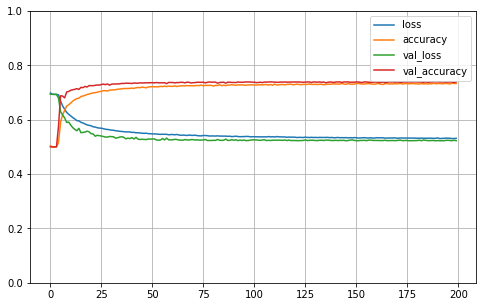

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7067 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.4986
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.4986
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4986
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5065 - val_loss: 0.6928 - val_accuracy: 0.5014
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6887 - accuracy: 0.5279 - val_loss: 0.6419 - val_accuracy: 0.6872
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6630 - a

Epoch 57/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5459 - accuracy: 0.7240 - val_loss: 0.5235 - val_accuracy: 0.7376
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5447 - accuracy: 0.7249 - val_loss: 0.5285 - val_accuracy: 0.7382
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5489 - accuracy: 0.7206 - val_loss: 0.5294 - val_accuracy: 0.7319
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5460 - accuracy: 0.7210 - val_loss: 0.5326 - val_accuracy: 0.7315
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5450 - accuracy: 0.7253 - val_loss: 0.5262 - val_accuracy: 0.7370
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5467 - accuracy: 0.7214 - val_loss: 0.5243 - val_accuracy: 0.7375
Epoch 63/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5483 - accuracy: 0.7212 - val_loss: 0.5257 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5403 - accuracy: 0.7269 - val_loss: 0.5216 - val_accuracy: 0.7401
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 113/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5383 - accuracy: 0.7280 - val_loss: 0.5257 - val_accuracy: 0.7367
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5357 - accuracy: 0.7297 - val_loss: 0.5219 - val_accuracy: 0.7387
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5420 - accuracy: 0.7242 - val_loss: 0.5257 - val_accuracy: 0.7370
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5353 - accuracy: 0.7306 - val_loss: 0.5249 - val_accuracy: 0.7388
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5337 - accuracy: 0.7312 - val_loss: 0.5213 - val_accuracy: 0.7382
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - lo

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5357 - accuracy: 0.7300 - val_loss: 0.5213 - val_accuracy: 0.7393
Epoch 167/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5330 - accuracy: 0.7309 - val_loss: 0.5227 - val_accuracy: 0.7381
Epoch 168/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5291 - accuracy: 0.7348 - val_loss: 0.5203 - val_accuracy: 0.7401
Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5304 - accuracy: 0.7345 - val_loss: 0.5211 - val_accuracy: 0.7386
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5315 - accuracy: 0.7339 - val_loss: 0.5209 - val_accuracy: 0.7396
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5350 - accuracy: 0.7329 - val_loss: 0.5206 - val_accuracy: 0.7385
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5329 - accuracy: 0.7327 - val_loss: 0.5222 - val_ac

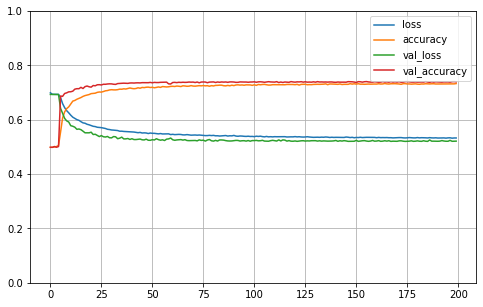

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7079 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.5013
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6929 - val_accuracy: 0.6713
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6896 - accuracy: 0.5276 - val_loss: 0.6512 - val_accuracy: 0.6670
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6646 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5464 - accuracy: 0.7237 - val_loss: 0.5256 - val_accuracy: 0.7365
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5468 - accuracy: 0.7202 - val_loss: 0.5280 - val_accuracy: 0.7368
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5461 - accuracy: 0.7228 - val_loss: 0.5268 - val_accuracy: 0.7381
Epoch 60/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5425 - accuracy: 0.7256 - val_loss: 0.5270 - val_accuracy: 0.7381
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5438 - accuracy: 0.7238 - val_loss: 0.5257 - val_accuracy: 0.7369
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5437 - accuracy: 0.7231 - val_loss: 0.5255 - val_accuracy: 0.7371
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5433 - accuracy: 0.7239 - val_loss: 0.5317 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5350 - accuracy: 0.7283 - val_loss: 0.5231 - val_accuracy: 0.7389
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5399 - accuracy: 0.7257 - val_loss: 0.5238 - val_accuracy: 0.7389
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5395 - accuracy: 0.7262 - val_loss: 0.5238 - val_accuracy: 0.7385
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5385 - accuracy: 0.7270 - val_loss: 0.5239 - val_accuracy: 0.7385
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5375 - accuracy: 0.7254 - val_loss: 0.5240 - val_accuracy: 0.7374
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5337 - accuracy: 0.7311 - val_loss: 0.5255 - val_accuracy: 0.7383
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5350 - accuracy: 0.7296 - val_loss: 0.5252 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5330 - accuracy: 0.7319 - val_loss: 0.5235 - val_accuracy: 0.7383
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5279 - accuracy: 0.7356 - val_loss: 0.5243 - val_accuracy: 0.7386
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5302 - accuracy: 0.7354 - val_loss: 0.5244 - val_accuracy: 0.7371
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5340 - accuracy: 0.7314 - val_loss: 0.5236 - val_accuracy: 0.7390
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5291 - accuracy: 0.7344 - val_loss: 0.5240 - val_accuracy: 0.7375
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5346 - accuracy: 0.7280 - val_loss: 0.5235 - val_accuracy: 0.7388
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5353 - accuracy: 0.7285 - val_loss: 0

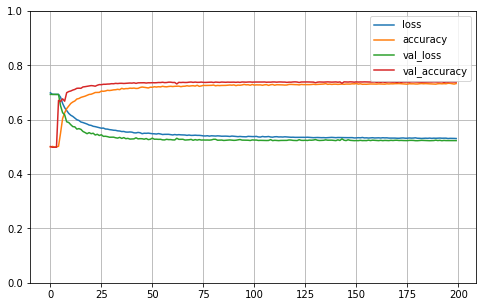

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [14]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-17 14:37:52 EDT


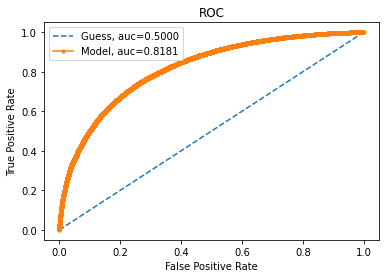

AUC: 81.81%
accuracy: 74.00%
2021-08-17 14:37:55 EDT


In [16]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-17 14:37:57 EDT


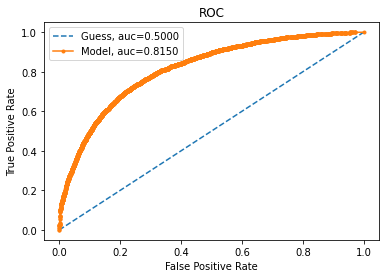

AUC: 81.50%
accuracy: 74.15%
2021-08-17 14:37:58 EDT


In [17]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()